In [1]:
#Import required function
import numpy as np
from scipy.interpolate import interp1d
import h5py
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
%matplotlib notebook

First import uncleaned data from Hanford during O1.

time =  4096  namples =  16777216  sample rate =  4096


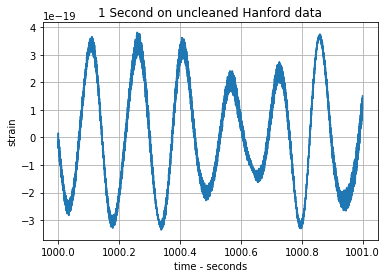

In [2]:
#Read a peice of strain data and make a time vector
filename = './Data/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
f = h5py.File(filename, 'r')
strain = f['strain/Strain'][()]
dt = f['strain/Strain'].attrs['Xspacing']
tstart = f['meta/GPSstart'][()]
tend = f['meta/Duration'][()] + tstart
f.close()

#Create a time vector starting at 0, and get the sampling frequency
ts = np.arange(0, tend-tstart, dt)
fs = int(1/dt)
print('time = ', (tend - tstart), ' namples = ', len(strain), ' sample rate = ', fs)

#Plot 1 second of strain data
plt.figure()
plt.plot(ts[1000*fs:1001*fs], strain[1000*fs:1001*fs])
plt.title('1 Second on uncleaned Hanford data')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

Next generate a waveform of known parameters to input into the data for matched filtering

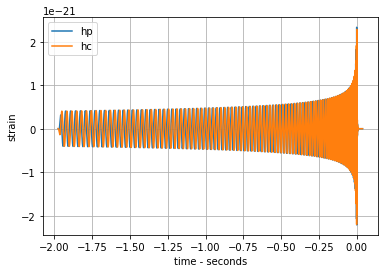

In [3]:
def Hann(n, N):
    """Evalute a Hann window of length N at n"""
    y = 0.5*(1-np.cos(2*np.pi*n/(N-1)))
    return y


#Use pycbc to produce waveform, then convert to numpy array and smooth turn on
hp0, hc0 = get_td_waveform(approximant="SEOBNRv4_opt", mass1=10, mass2=10, delta_t=dt, f_lower=30, distance = 100)
hp = hp0.numpy()
hp[:100] *= Hann(np.arange(100), 200)
hc = hc0.numpy()
hc[:100] *= Hann(np.arange(100), 200)
ht = hp0.sample_times.numpy()

#Plot both polarisations
plt.figure()
plt.plot(ht, hp, label='hp')
plt.plot(ht, hc, label='hc')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.legend()
plt.grid()

Next imput signal into data

Event time =  1855.3173828125


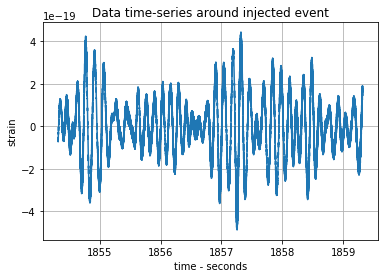

In [4]:
#Place data within noise
eventi = int( np.random.rand(1) * (len(strain) - len(ht)) )
eventt = eventi*dt
data = np.zeros((len(strain)), dtype='float')
data[eventi:eventi+len(ht)] += hp
data += strain
print('Event time = ', eventt)

#Plot new data time series around event
plt.figure()
plt.plot(ts[eventi-fs:eventi+fs*4], strain[eventi-fs:eventi+fs*4])
plt.title('Data time-series around injected event')
plt.xlabel('time - seconds')
plt.ylabel('strain')
plt.grid()

Now calculate the psd of the data using Welch's method, then whiten the data (whitened data won't be used in the match filtering, doing this purely for inspection).

/home/mcisaacc/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


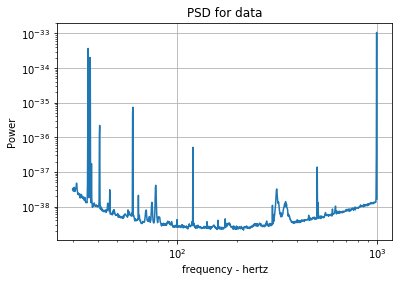

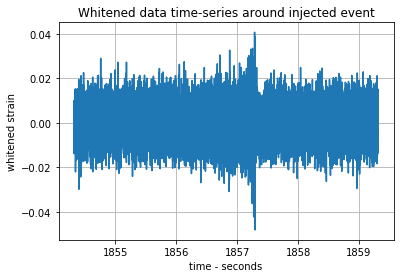

In [5]:
def calcpsd(x, y, windowl, window):
    """Calculate the PSD from the signal time series averaged from the PSDs of length windowl.
    Use given window to smooth each fft. Return the PSD as an interpolated function"""
    dx = x[1] - x[0]
    neach = int(windowl/dx)
    nfft = int(2 * len(y)//neach - 1)
    shift = int(np.ceil(neach/2))
    freq = np.fft.rfftfreq(neach, dx)
    asds = np.zeros((nfft, len(freq)), dtype='complex')
    psds = np.zeros((nfft, len(freq)), dtype='complex')
    for i in range(0, nfft):
        windowed = y[i*shift:i*shift + neach]*window(np.arange(neach), neach)
        asds[i, :] = np.fft.rfft(windowed)
        psds[i, :] = asds[i, :]*np.conj(asds[i, :])
    psd = np.mean(psds**(0.5), axis=0)**2
    psdi = interp1d(freq, psd, axis=0, bounds_error=False, fill_value=0)
    return psdi


def whiten(x, y, psdi):
    """use interpolated psd to whiten given data"""
    dx = x[1] - x[0]
    num = np.size(x)
    freqs = np.fft.rfftfreq(num, dx)
    yft = np.fft.rfft(y)
    white_yft = yft/(np.sqrt(psdi(freqs)))
    white_y = np.fft.irfft(white_yft, n=num)
    return np.real(white_y)


#Apply functions to data to find psd and whiten data
psdcut = 16    #Length in seconds of the window used in Welch's method and truncation
psdi = calcpsd(ts, data, psdcut, Hann)
white_strain = whiten(ts, data, psdi)

#Plot PSD evaluated from 30 to 500Hz
fplot = np.geomspace(30, 1000, num=1000, endpoint=True)
plt.figure()
plt.plot(fplot, psdi(fplot))
plt.xscale('log')
plt.yscale('log')
plt.title('PSD for data')
plt.xlabel('frequency - hertz')
plt.ylabel('Power')
plt.grid()

#Plot whitened data around event
plt.figure()
plt.plot(ts[eventi-fs:eventi+fs*4], white_strain[eventi-fs:eventi+fs*4])
plt.title('Whitened data time-series around injected event')
plt.xlabel('time - seconds')
plt.ylabel('whitened strain')
plt.grid()

Next the psd must be inverted, inverse fourier transformed, truncated and fourier transformed to reduce the impulse response of the matched filter.

In [6]:
def itrunc_psd(psdi, psdcut, datax):
    """inverts and trucates the psd for use in matched filtering.
    Evaluate the psd at the resolution of the data and invert it.
    Then inverse fourier transform the result and truncate to psdcut.
    Finally fourier transform this back to the frequency domain."""
    dx = datax[1]-datax[0]
    fs = int(1/dx)
    freqs = np.fft.rfftfreq(len(datax), dx)
    inv_psd = 1/psdi(freqs)
    inv_psd_t = np.fft.irfft(inv_psd)
    cutstart = int(len(inv_psd_t)//2) - int(psdcut*fs/2)
    inv_psd_tcut = inv_psd_t[cutstart:cutstart+psdcut*fs]
    itrunc_f = np.fft.rfftfreq(len(inv_psd_tcut), dx)
    itrunc_a = np.fft.rfft(inv_psd_tcut)
    itrunc = interp1d(itrunc_f, (itrunc_a*np.conj(itrunc_a))**0.5, axis=0, bounds_error=False, fill_value=0)
    return itrunc


it_psd = itrunc_psd(psdi, psdcut, ts)

The basic SNR time-series can now be calculated

Max SNR at t = 1855.3174933980401     Event missed by t =  0.00011058554014198307


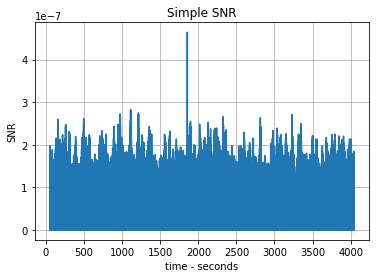

In [7]:
def inner(xdata, ydata, xtemp, ytemp, it_psd, ift=True):
    """Perform the inner product of two signals given in the time domain
    return the resulting time-series. Assuming the resolutions are equal"""
    dx = xdata[1] - xdata[0]
    if len(ydata) < len(ytemp):
        xft = np.fft.rfftfreq(len(xtemp), dx)
        y2ft = np.fft.rfft(ytemp)
        y1 = np.zeros((len(xtemp)), dtype='float')
        y1[:len(ydata)] += ydata
        y1ft = np.fft.rfft(y1)
    elif len(ytemp) < len(ydata):
        xft = np.fft.rfftfreq(len(xdata), dx)
        y1ft = np.fft.rfft(ydata)
        y2 = np.zeros((len(xdata)), dtype='float')
        y2[:len(ytemp)] += ytemp
        y2ft = np.fft.rfft(y2)
    else:
        xft = np.fft.rfftfreq(len(xdata), dx)
        y1ft = np.fft.rfft(ydata)
        y2ft = np.fft.rfft(ytemp)
    y3ft = it_psd(xft)
    innerft = y1ft*np.conj(y2ft)*y3ft
    if ift == False:
        return xft, innerft
    else:
        yinner0 = np.fft.irfft(innerft)
        yinner = (yinner0*np.conj(yinner0))**0.5
        dt = 1/(len(yinner)*(xft[1] - xft[0]))
        xinner = np.linspace(0, len(yinner)*dt, num=len(yinner))
        return xinner, yinner


tsnr0, snr0 = inner(ts, data, ht, hp, it_psd)
tsnr = tsnr0[50*fs:-50*fs]
snr = 4*snr0[50*fs:-50*fs]
plt.figure()
plt.plot(tsnr, snr)
plt.title('Simple SNR')
plt.xlabel('time - seconds')
plt.ylabel('SNR')
plt.grid()

print('Max SNR at t =', tsnr[np.argmax(snr)], '    Event missed by t = ', np.abs(eventt-tsnr[np.argmax(snr)]))

Next apply a chi squared statistic by binning the template into bins of equal power and comparing the SNR of each with the data to the expected SNR.

Min chi at t = 1563.0584427749181     Event missed by t =  292.25894003758185


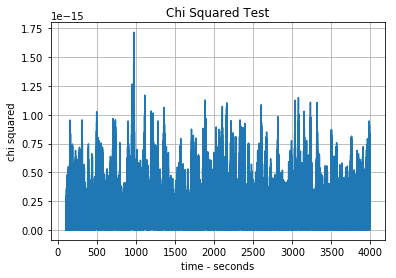

In [14]:
def chi_squared(xdata, ydata, xtemp, ytemp, it_psd, nbins):
    templates = np.zeros((len(xtemp), nbins), dtype='float')
    power = sum(ytemp**2)
    used = 0
    pbins = np.zeros((nbins), dtype='float')
    for i in range(0, nbins-1):
        pbin = 0
        count = 0
        while pbin < power/nbins:
            templates[used+count, i] = ytemp[used+count]
            #templates[:100, i] *= Hann(np.arange(100), 200)
            #templates[-100:, i] *= Hann(100 + np.arange(100), 200)
            pbin += ytemp[used+count]**2
            count += 1
        used += count
        pbins[i] = pbin
    templates[used:, nbins-1] = ytemp[used:]
    pbins[-1] = sum(ytemp[used:]**2)
    """
    plt.figure()
    for i in range(0, nbins):
        plt.subplot(nbins, 1, i+1)
        plt.plot(xtemp, templates[:, i])
    """
    x0, snr0 = inner(xdata, ydata, xtemp, ytemp, it_psd)
    x = x0[50*fs:-50*fs]
    snr = snr0[50*fs:-50*fs]
    psnr = np.zeros((len(snr), nbins), dtype='float')
    for i in range(0, nbins):
        _, psnr0 = inner(xdata, ydata, xtemp, templates[:, i], it_psd)
        psnr[:, i] = np.abs(psnr0[50*fs:-50*fs])
    chi_each = np.zeros((len(snr), nbins), dtype='float')
    for i in range(0, nbins):
        chi_each[:, i] = (psnr[:, i] - snr*(pbins[i]/power))**2
    """
    for i in range(0, nbins):
        plt.figure()
        plt.plot(x, psnr[:, i])
    for i in range(0, nbins):
        plt.plot(x, chi_each[:, i])
    plt.show()
    """
    chi = np.sum(chi_each, axis=1)
    rsnr = np.zeros((len(snr)), dtype='float')
    for i in range(0, len(snr)):
        if chi[i] > 1:
            rsnr[i] = snr[i]/(((1 + chi[i]**3)/2.)**(1/6.))
        else:
            rsnr[i] = snr[i]
    return x, snr, chi, rsnr


tchi0, chisnr0, chi0, rsnr0 = chi_squared(ts, data, ht, hp, it_psd, 8)
tchi = tchi0[50*fs:-50*fs]
chisnr = 4*chisnr0[50*fs:-50*fs]
chi = chi0[50*fs:-50*fs]
rsnr = rsnr0[50*fs:-50*fs]
plt.figure()
plt.plot(tchi, chi)
plt.title('Chi Squared Test')
plt.xlabel('time - seconds')
plt.ylabel('chi squared')
plt.grid()

print('Min chi at t =', tsnr[np.argmin(chi)], '    Event missed by t = ', np.abs(eventt-tsnr[np.argmin(chi)]))